# MNIST Low Precision Training Example
In this notebook, we present a quick example of how to simulate training a deep neural network in low precision with QPyTorch.

## 1. Training MNIST in Floating Point

In [1]:
# import useful modules
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from qtorch.quant import Quantizer
from qtorch.optim import OptimLP
from torch.optim import SGD
from qtorch import BlockFloatingPoint, FloatingPoint, FixedPoint
from tqdm import tqdm

Time execution

In [2]:
import time
start_time = time.time()

We first load the data. In this example, we will experiment with MNIST.

In [3]:
# loading data
ds = torchvision.datasets.MNIST
path = os.path.join("./data", "MNIST")
transform_train = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))])
transform_test = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])
train_set = ds(path, train=True, download=True, transform=transform_train)
test_set = ds(path, train=False, download=True, transform=transform_test)
loaders = {
        'train': torch.utils.data.DataLoader(
            train_set,
            batch_size=64,
            shuffle=True,
            num_workers=1,
            pin_memory=True
        ),
        'test': torch.utils.data.DataLoader(
            test_set,
            batch_size=64,
            num_workers=1,
            pin_memory=True
        )
}

0it [00:00, ?it/s]

9920512it [00:01, 6392511.43it/s]                             


Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 120619.63it/s]           
0it [00:00, ?it/s]

Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 1829725.64it/s]                            
0it [00:00, ?it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 45532.08it/s]            


Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


We then define the quantization setting we are going to use. We define a low and high precision format for different parts of the computation.

In [4]:
# define two floating point formats
lowp = FixedPoint(wl=8, fl=7)
highp = FloatingPoint(exp=8, man=7)  # this is bfloat16

# define quantization functions
weight_quant = Quantizer(forward_number=lowp, backward_number=None,
                        forward_rounding="nearest", backward_rounding="nearest")
grad_quant = Quantizer(forward_number=lowp, backward_number=None,
                        forward_rounding="nearest", backward_rounding="stochastic")
momentum_quant = Quantizer(forward_number=highp, backward_number=None,
                        forward_rounding="nearest", backward_rounding="stochastic")
acc_quant = Quantizer(forward_number=highp, backward_number=None,
                        forward_rounding="nearest", backward_rounding="nearest")

# define a lambda function so that the Quantizer module can be duplicated easily
act_error_quant = lambda : Quantizer(forward_number=lowp, backward_number=lowp,
                        forward_rounding="nearest", backward_rounding="nearest")

Next, we define a simple LeNet network. 

In [5]:
# let's define the model we are using
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)



We now use the low-precision optimizer wrapper to help define the quantization of weight, gradient, momentum, and gradient accumulator.

In [6]:
use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
optimizer = SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=1e-4)
mxepochs = 10

We can reuse common training scripts without any extra codes to handle quantization.

In [7]:
def run_epoch(loader, model, criterion, optimizer=None, phase="train"):
    assert phase in ["train", "eval"], "invalid running phase"
    loss_sum = 0.0
    correct = 0.0

    if phase=="train": model.train()
    elif phase=="eval": model.eval()

    ttl = 0
    with torch.autograd.set_grad_enabled(phase=="train"):
        for i, (input, target) in tqdm(enumerate(loader), total=len(loader)):
            input = input.to(device=device)
            target = target.to(device=device)
            output = model(input)
            loss = criterion(output, target)
            loss_sum += loss.cpu().item() * input.size(0)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            ttl += input.size()[0]

            if phase=="train":
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    correct = correct.cpu().item()
    return {
        'loss': loss_sum / float(ttl),
        'accuracy': correct / float(ttl) * 100.0,
    }

Run the training in floating point.

In [8]:
for epoch in range(mxepochs):
    fp_train_res = run_epoch(loaders['train'], model, F.cross_entropy,
                            optimizer=optimizer, phase="train")
    fp_test_res = run_epoch(loaders['test'], model, F.cross_entropy,
                            optimizer=optimizer, phase="eval")
    print('epoch', epoch)
    print(fp_train_res)
    print(fp_test_res)

100%|██████████| 157/157 [00:02<00:00, 54.02it/s]

epoch 0
{'loss': 0.13607263702514272, 'accuracy': 95.73166666666667}
{'loss': 0.05042032431769185, 'accuracy': 98.37}



100%|██████████| 157/157 [00:02<00:00, 60.52it/s]

epoch 1
{'loss': 0.04660116978312532, 'accuracy': 98.605}
{'loss': 0.039288322220509875, 'accuracy': 98.78}



100%|██████████| 157/157 [00:02<00:00, 59.94it/s]

epoch 2
{'loss': 0.03134131622233351, 'accuracy': 99.08500000000001}
{'loss': 0.027584416901902296, 'accuracy': 99.14}



100%|██████████| 157/157 [00:04<00:00, 34.57it/s]

epoch 3
{'loss': 0.025083318675485983, 'accuracy': 99.23166666666667}
{'loss': 0.0312590452823526, 'accuracy': 99.00999999999999}



100%|██████████| 157/157 [00:02<00:00, 64.76it/s]

epoch 4
{'loss': 0.019749159859724266, 'accuracy': 99.37166666666667}
{'loss': 0.027827660323987948, 'accuracy': 99.18}



100%|██████████| 157/157 [00:02<00:00, 60.16it/s]

epoch 5
{'loss': 0.017655720647089767, 'accuracy': 99.44666666666667}
{'loss': 0.029938086311386725, 'accuracy': 99.11}



100%|██████████| 157/157 [00:02<00:00, 52.75it/s]

epoch 6
{'loss': 0.009839267661239137, 'accuracy': 99.69333333333333}
{'loss': 0.027093405548988175, 'accuracy': 99.3}



100%|██████████| 157/157 [00:02<00:00, 56.23it/s]

epoch 7
{'loss': 0.012126508988343995, 'accuracy': 99.6}
{'loss': 0.03689758545774057, 'accuracy': 99.09}



100%|██████████| 157/157 [00:02<00:00, 66.17it/s]

epoch 8
{'loss': 0.012339169164924049, 'accuracy': 99.625}
{'loss': 0.029518506918489038, 'accuracy': 99.25}



100%|██████████| 157/157 [00:02<00:00, 64.52it/s]

epoch 9
{'loss': 0.01024819865362612, 'accuracy': 99.68666666666667}
{'loss': 0.02382945015741957, 'accuracy': 99.38}


## 2. Block Floating Point Inference

Now do it with low precision arithmetic. We first define the data types

In [9]:
# define two number formats, one low precision the other high
lowp = BlockFloatingPoint(wl=8, dim=-1)   
highp = FloatingPoint(exp=8, man=7)      # this is bfloat16

# define quantization functions
weight_quant = Quantizer(forward_number=lowp, backward_number=None,
                        forward_rounding="nearest", backward_rounding="nearest")
grad_quant = Quantizer(forward_number=lowp, backward_number=None,
                        forward_rounding="nearest", backward_rounding="stochastic")
momentum_quant = Quantizer(forward_number=highp, backward_number=None,
                        forward_rounding="nearest", backward_rounding="stochastic")
acc_quant = Quantizer(forward_number=highp, backward_number=None,
                        forward_rounding="nearest", backward_rounding="nearest")

# define a lambda function so that the Quantizer module can be duplicated easily
act_error_quant = lambda : Quantizer(forward_number=lowp, backward_number=lowp,
                        forward_rounding="nearest", backward_rounding="nearest")

Now we define the network. In the definition, we insert quantization module after every convolution layer. Note that the quantization of weight, gradient, momentum, and gradient accumulator are not handled here.

In [10]:
# let's define the model we are using
class lp_Net(nn.Module):
    def __init__(self, quant=None):
        super(lp_Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
        self.quant = quant()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.quant(x)
        x = F.max_pool2d(x, 2, 2)
        x = self.quant(x)
        x = F.relu(self.conv2(x))
        x = self.quant(x)
        x = F.max_pool2d(x, 2, 2)
        x = self.quant(x)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.quant(x)
        x = self.fc2(x)
        x = self.quant(x)
        return F.log_softmax(x, dim=1)

In [11]:
use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
model = lp_Net(act_error_quant).to(device)
optimizer = SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=1e-4)
lp_optimizer = OptimLP(optimizer,
                    weight_quant=weight_quant,
                    grad_quant=grad_quant,
                    momentum_quant=momentum_quant,
                    acc_quant=acc_quant
)
for epoch in range(mxepochs):
    train_res = run_epoch(loaders['train'], model, F.cross_entropy,
                                optimizer=lp_optimizer, phase="train")
    test_res = run_epoch(loaders['test'], model, F.cross_entropy,
                                optimizer=lp_optimizer, phase="eval")
    print('epoch', epoch)
    print(train_res)
    print(test_res)

100%|██████████| 157/157 [00:08<00:00, 18.21it/s]

epoch 0
{'loss': 0.13196566676584384, 'accuracy': 95.94500000000001}
{'loss': 0.0466696068122983, 'accuracy': 98.65}



100%|██████████| 157/157 [00:08<00:00, 19.32it/s]

epoch 1
{'loss': 0.044269972011664264, 'accuracy': 98.605}
{'loss': 0.0340605054948479, 'accuracy': 98.86}



100%|██████████| 157/157 [00:08<00:00, 18.93it/s]

epoch 2
{'loss': 0.028071887739025986, 'accuracy': 99.08666666666667}
{'loss': 0.041074718202487565, 'accuracy': 98.8}



100%|██████████| 157/157 [00:07<00:00, 20.48it/s]

epoch 3
{'loss': 0.021294757222306605, 'accuracy': 99.355}
{'loss': 0.03341474033953273, 'accuracy': 98.97}



100%|██████████| 157/157 [00:07<00:00, 20.51it/s]

epoch 4
{'loss': 0.015468017672479618, 'accuracy': 99.53833333333333}
{'loss': 0.03446901559790422, 'accuracy': 98.96000000000001}



100%|██████████| 157/157 [00:07<00:00, 22.02it/s]

epoch 5
{'loss': 0.013761486605556759, 'accuracy': 99.55666666666667}
{'loss': 0.0318010430190916, 'accuracy': 99.11999999999999}



100%|██████████| 157/157 [00:07<00:00, 22.47it/s]

epoch 6
{'loss': 0.009867132546248224, 'accuracy': 99.68166666666667}
{'loss': 0.034100452099219185, 'accuracy': 99.03999999999999}



100%|██████████| 157/157 [00:07<00:00, 20.58it/s]

epoch 7
{'loss': 0.011455022966711356, 'accuracy': 99.63}
{'loss': 0.036446592486812736, 'accuracy': 98.9}



100%|██████████| 157/157 [00:07<00:00, 20.54it/s]

epoch 8
{'loss': 0.009812804903862223, 'accuracy': 99.69}
{'loss': 0.03113835411135991, 'accuracy': 99.22999999999999}



100%|██████████| 157/157 [00:05<00:00, 26.87it/s]

epoch 9
{'loss': 0.006254680718504824, 'accuracy': 99.81333333333333}
{'loss': 0.03364552705139886, 'accuracy': 99.13}


## 3. Accuracy vs wordlength

In this section, generate a plot of accuracy vs wordlength using the implementation given in the previous sections as a starting point. What precision gives the best accuracy?

In [12]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

Compute NN accuracy vs wordlength. Place appropriate code below.

In [16]:
# dummy code here that just populates the res list
res = []
(minp, maxp) = (1,8)
for i in range(minp, maxp+1):
    res.append((i, 90 + i / 10))
print(res)

[(1, 90.1), (2, 90.2), (3, 90.3), (4, 90.4), (5, 90.5), (6, 90.6), (7, 90.7), (8, 90.8)]


Make a scatterplot of the results, also draw a line to show the floating point result

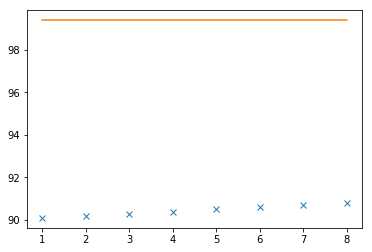

In [17]:
plt_res=np.array(res)
plt.plot(plt_res[:,0], plt_res[:,1], 'x')
plt.plot((minp,maxp),(fp_test_res['accuracy'], fp_test_res['accuracy']))


In [18]:
print("Total execution time (s):", time.time() - start_time)

Total execution time (s): 2124.912360906601
